In [13]:
import torch, torchvision, os, pathlib, random
import pytorch_lightning as pl
import torch.utils.data  
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil



### 1. Getting data ready

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
data_path = pathlib.Path('dataset')
def walk_dir(path):
    for root, dirs, files in os.walk(path):
        print(f'root: {root}')
        for file in files:
            print(f'file: {file}')

            

walk_dir(data_path)

root: dataset
root: dataset\testx
file: IMD021.bmp
file: IMD022.bmp
file: IMD040.bmp
file: IMD065.bmp
file: IMD103.bmp
file: IMD112.bmp
file: IMD132.bmp
file: IMD133.bmp
file: IMD134.bmp
file: IMD135.bmp
file: IMD137.bmp
file: IMD149.bmp
file: IMD154.bmp
file: IMD156.bmp
file: IMD169.bmp
file: IMD171.bmp
file: IMD240.bmp
file: IMD284.bmp
file: IMD285.bmp
file: IMD306.bmp
file: IMD339.bmp
file: IMD376.bmp
file: IMD381.bmp
file: IMD388.bmp
file: IMD396.bmp
file: IMD402.bmp
file: IMD406.bmp
file: IMD409.bmp
file: IMD418.bmp
file: IMD423.bmp
root: dataset\testy
file: IMD021_lesion.bmp
file: IMD022_lesion.bmp
file: IMD040_lesion.bmp
file: IMD065_lesion.bmp
file: IMD103_lesion.bmp
file: IMD112_lesion.bmp
file: IMD132_lesion.bmp
file: IMD133_lesion.bmp
file: IMD134_lesion.bmp
file: IMD135_lesion.bmp
file: IMD137_lesion.bmp
file: IMD149_lesion.bmp
file: IMD154_lesion.bmp
file: IMD156_lesion.bmp
file: IMD169_lesion.bmp
file: IMD171_lesion.bmp
file: IMD240_lesion.bmp
file: IMD284_lesion.bmp
file

In [16]:
trainx_path = data_path / Path("trainx")
trainy_path = data_path / Path("trainy") 

# 1.1Visualising Random images and masks 

In [17]:
def plot_random_image_and_masks(image_path,mask_path):

    random_image_path = random.choice(list(image_path.glob('*.bmp')))
    print(random_image_path)
    print(mask_path)
    mask_file_name = random_image_path.stem + "_lesion" + random_image_path.suffix
    random_mask_path = mask_path / mask_file_name
    print(random_mask_path)

    image = Image.open(random_image_path)
    mask = Image.open(random_mask_path)
    sample_transform = torchvision.transforms.ToTensor()
    print(sample_transform(image).shape)
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image (trainx)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title("Mask Image (trainy)")
    plt.axis('off')
    plt.show()






dataset\trainx\IMD381.bmp
dataset\trainy
dataset\trainy\IMD381_lesion.bmp
torch.Size([3, 576, 767])


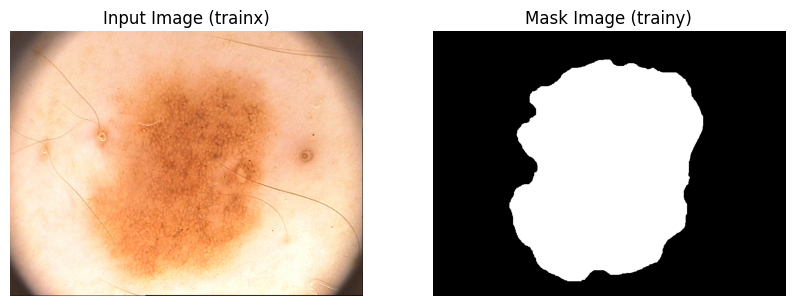

In [18]:
plot_random_image_and_masks(trainx_path,trainy_path)

# 1.2 splitting data into train and test 

In [19]:
def split_dataset(image_dir, mask_dir, test_ratio=0.15, output_dir="dataset"):
    """
    Splits the dataset into training and testing sets.

    Args:
        image_dir (str): Path to the directory containing the input images.
        mask_dir (str): Path to the directory containing the segmentation masks.
        test_ratio (float): Fraction of the dataset to use for testing.
        output_dir (str): Directory where the split dataset will be saved.

    Returns:
        None
    """
    image_dir = Path(image_dir)
    mask_dir = Path(mask_dir)
    output_dir = Path(output_dir)

    testx_output = output_dir / "testx"
    testy_output = output_dir / "testy"

    
    testx_output.mkdir(parents=True, exist_ok=True)
    testy_output.mkdir(parents=True, exist_ok=True)

    # Get all image files
    image_files = sorted(list(image_dir.glob('*')))  # Adjust glob pattern as needed (e.g., '*.png')
    mask_files = [
        mask_dir / (image_file.stem + "_lesion" + image_file.suffix)
        for image_file in image_files
    ]

    # Ensure masks exist for all images
    assert all(mask.exists() for mask in mask_files), "Some masks are missing for the corresponding images."

    # Split dataset
    train_images, test_images, train_masks, test_masks = train_test_split(
        image_files, mask_files, test_size=test_ratio, random_state=42
    )

    for image in test_images:
        shutil.copy(image, testx_output / image.name)
    for mask in test_masks:
        shutil.copy(mask, testy_output / mask.name)

    print(f"Dataset split completed:")
    print(f"Train set: {len(train_images)} images, {len(train_masks)} masks")
    print(f"Test set: {len(test_images)} images, {len(test_masks)} masks")
    print(f"Output saved to: {output_dir}")


split_dataset(trainx_path, trainy_path, test_ratio=0.15, output_dir="dataset")

Dataset split completed:
Train set: 170 images, 170 masks
Test set: 30 images, 30 masks
Output saved to: dataset


### 1.3 creating  Train and Test DataLoaders

creating a class for ph2dataset, which whill gives us a `torch.utils.data.Dataset` instance

In [20]:
class Ph2Dataset(torch.utils.data.Dataset):
    def __init__(self, image_dir,mask_dir,
                 transform=torchvision.transforms.ToTensor()):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.image_files = sorted(list(self.image_dir.glob('*')))
        self.mask_files =[
            self.mask_dir / (image_file.stem + "_lesion" + image_file.suffix)
            for image_file in self.image_files
        ]
        self.transform = transform
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')
        mask = Image.open(self.mask_files[idx]).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask
    


`create_dataloaders` function returns train and test dataloader of the type `torch.utils.data.DataLoader`

In [21]:
def create_dataloaders(
    trainx_path, trainy_path, testx_path, testy_path, batch_size=8, num_workers=os.cpu_count()    
):
    # Augument Dataset
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.RandomRotation(degrees=90),  # rotation_range=90
        # torchvision.transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),  # width_shift_range=0.3, height_shift_range=0.3
        # torchvision.transforms.RandomAffine(degrees=0, shear=0.5),  # shear_range=0.5
        # torchvision.transforms.RandomResizedCrop(size=(128, 128), scale=(0.7, 1.3)),  # zoom_range=0.3
        # torchvision.transforms.RandomHorizontalFlip(p=1.0),  # horizontal_flip=True
        # torchvision.transforms.RandomVerticalFlip(p=1.0),  # vertical_flip=True
        # torchvision.transforms.Pad(padding=10, padding_mode='reflect'),  # fill_mode='reflect'

    ])

    train_dataset = Ph2Dataset(trainx_path, trainy_path, transform=transform)
    test_dataset = Ph2Dataset(testx_path, testy_path, transform=transform)

    #Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_loader, test_loader
    

In [22]:
trainx_path = data_path / Path("trainx")
trainy_path = data_path / Path("trainy")
testx_path = data_path / Path("testx")
testy_path = data_path / Path("testy")

In [23]:
train_dataloader , test_dataloader = create_dataloaders(
    trainx_path, trainy_path, testx_path, testy_path, batch_size=8, num_workers=0
)


In [24]:
next(iter(train_dataloader))[0].shape

torch.Size([8, 3, 256, 256])

### 2. Replicating the UNet Model 

# 2.1 Left part

In [25]:


conv_bottle_neck = torch.nn.Sequential(
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(512, 1024, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(1024, 1024, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
)

conv_decoder_block_4 = torch.nn.Sequential(
    torch.nn.Conv2d(1024, 512, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(512, 512, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
)
conv_decoder_block_3 = torch.nn.Sequential(
    torch.nn.Conv2d(512, 256, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(256, 256, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
)
conv_decoder_block_2 = torch.nn.Sequential(
    torch.nn.Conv2d(256, 128, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 128, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
)
conv_decoder_block_1 = torch.nn.Sequential(
    torch.nn.Conv2d(128, 64, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 64, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 1, kernel_size=1)
)




In [26]:
conv_encoder_block_1 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 64, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 64, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    
    
)
conv_encoder_block_2 = torch.nn.Sequential(
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(64, 128, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 128, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    
    
)
conv_encoder_block_3 = torch.nn.Sequential(
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(128,256, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(256, 256, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    
)
conv_encoder_block_4 = torch.nn.Sequential(
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(256, 512, kernel_size=3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(512, 512, kernel_size=3, padding = 1),
    torch.nn.ReLU()
    

)

In [27]:
from torchmetrics.classification import BinaryJaccardIndex

class UNet(pl.LightningModule):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block_1 = conv_encoder_block_1
        self.encoder_block_2 = conv_encoder_block_2
        self.encoder_block_3 = conv_encoder_block_3
        self.encoder_block_4 = conv_encoder_block_4
        self.bottle_neck = conv_bottle_neck
        self.decoder_block_4 = conv_decoder_block_4
        self.decoder_block_3 = conv_decoder_block_3
        self.decoder_block_2 = conv_decoder_block_2
        self.decoder_block_1 = conv_decoder_block_1
        self.jaccard = BinaryJaccardIndex()
    def forward(self, x):
        encoder_1 = self.encoder_block_1(x)
        encoder_2 = self.encoder_block_2(encoder_1)
        encoder_3 = self.encoder_block_3(encoder_2)
        encoder_4 = self.encoder_block_4(encoder_3)
        bottle_neck = self.bottle_neck(encoder_4)
        decoder_4 = self.decoder_block_4(torch.cat((bottle_neck, encoder_4), 1))
        decoder_3 = self.decoder_block_3(torch.cat((decoder_4, encoder_3), 1))
        decoder_2 = self.decoder_block_2(torch.cat((decoder_3, encoder_2), 1))
        decoder_1 = self.decoder_block_1(torch.cat((decoder_2, encoder_1), 1))

        return decoder_1    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x.to(device), y.to(device)  
        y_hat = self(x)  # Apply Sigmoid here
        loss = torch.nn.BCEWithLogitsLoss()(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x.to(device), y.to(device)
        y_hat = torch.sigmoid(self(x))  # Apply Sigmoid here
        loss = torch.nn.BCELoss()(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x.to(device), y.to(device)
        y_hat = torch.sigmoid(self(x))
        loss = torch.nn.BCELoss()(y_hat, y)
        
        self.log('test_loss', loss)
        
    

    
    


In [28]:
next(iter(train_dataloader))[1].shape

torch.Size([8, 1, 256, 256])

In [29]:
model = UNet()
model.forward(torch.randn(8, 3, 256, 256)).shape

torch.Size([8, 1, 256, 256])

In [38]:
from pytorch_lightning.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',  # Metric to monitor
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='unet-{epoch:02d}-{val_loss:.2f}',  # Checkpoint filename
    save_top_k=1,  # Save the top 3 checkpoints
    mode='min'  # Minimize the monitored metric
)

In [54]:
checkpoint_path = checkpoint_callback.best_model_path
checkpoint_path

'C:\\Users\\siddh\\OneDrive\\Desktop\\Paper_Replicating_PyTorch\\UNet\\checkpoints\\unet-epoch=68-val_loss=0.06.ckpt'

In [55]:
import mlflow
from pytorch_lightning.loggers import MLFlowLogger
# Initialize the MLFlow logger
mlflow_logger = MLFlowLogger(
    experiment_name='UNet_Replication',
    tracking_uri="http://127.0.0.1:5000"
)
with mlflow.start_run(run_name="UNet_Replication_without_data_augmentation"):
    trainer = pl.Trainer(
        logger=mlflow_logger,
        max_epochs=100,  # Change this based on your setup
        log_every_n_steps=10,
        callbacks=[checkpoint_callback]  # Add the checkpoint callback
    )

model = UNet().to(device)
trainer.fit(model, train_dataloader, test_dataloader,ckpt_path=checkpoint_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\siddh\anaconda3\envs\myenv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\siddh\OneDrive\Desktop\Paper_Replicating_PyTorch\UNet\checkpoints exists and is not empty.
Restoring states from the checkpoint path at C:\Users\siddh\OneDrive\Desktop\Paper_Replicating_PyTorch\UNet\checkpoints\unet-epoch=68-val_loss=0.06.ckpt


🏃 View run UNet_Replication_without_data_augmentation at: http://127.0.0.1:5000/#/experiments/0/runs/ec561eb8818a43978e539269b4d8e1c7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | encoder_block_1 | Sequential         | 38.7 K | eval 
1 | encoder_block_2 | Sequential         | 221 K  | eval 
2 | encoder_block_3 | Sequential         | 885 K  | eval 
3 | encoder_block_4 | Sequential         | 3.5 M  | eval 
4 | bottle_neck     | Sequential         | 16.3 M | eval 
5 | decoder_block_4 | Sequential         | 7.6 M  | eval 
6 | decoder_block_3 | Sequential         | 1.9 M  | eval 
7 | decoder_block_2 | Sequential         | 475 K  | eval 
8 | decoder_block_1 | Sequential         | 110 K  | eval 
9 | jaccard         | BinaryJaccardIndex | 0      | train
---------------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.127   Total estimated model params size (MB)
1         Modules in train mode
54        Modules in eval mod

Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\siddh\anaconda3\envs\myenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


c:\Users\siddh\anaconda3\envs\myenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s, v_num=d721, train_loss_step=0.0343, val_loss=0.0618, train_loss_epoch=0.066] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s, v_num=d721, train_loss_step=0.0343, val_loss=0.0618, train_loss_epoch=0.066]
🏃 View run 100_epochs_batch_size_8 at: http://127.0.0.1:5000/#/experiments/767049568647656182/runs/5e5a14e079dc46f0b41d97bcf61dd721
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/767049568647656182


In [56]:
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\siddh\anaconda3\envs\myenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.061828065663576126    │
└───────────────────────────┴───────────────────────────┘

🏃 View run 100_epochs_batch_size_8 at: http://127.0.0.1:5000/#/experiments/767049568647656182/runs/5e5a14e079dc46f0b41d97bcf61dd721
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/767049568647656182


[{'test_loss': 0.061828065663576126}]

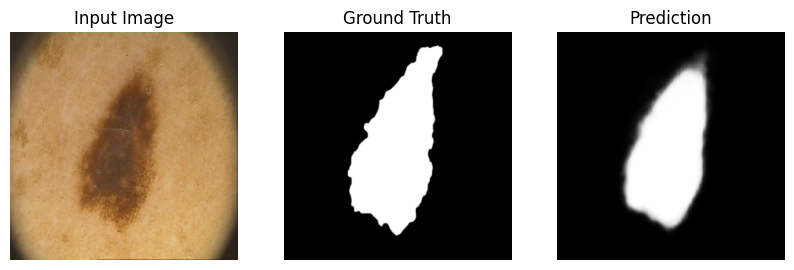

In [57]:
import random
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def make_predictions_and_compare(model, test_dataloader):
    
    
    model.eval()
    with torch.no_grad():
        # Randomly select a batch from the test dataloader
        batch = random.choice(list(test_dataloader))
        x, y = batch[0], batch[1]
        
        
        # Make predictions
        y_hat = torch.sigmoid(model(x))

    # Convert tensors to numpy arrays
    x_np = x[0].permute(1, 2, 0).cpu().numpy()
    y_np = y[0].squeeze().cpu().numpy()
    y_hat_np = y_hat[0].squeeze().detach().cpu().numpy()

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(x_np)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(y_np, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_np, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.show()

# Example usage
make_predictions_and_compare(model, test_dataloader)